# Set Random Number Seed (for Reproducibility)

In [1]:
import random
random.seed(101)

# Input Data (Edit for Your Particular Dataset)

In [2]:
# This example assumes the use of csv data, loaded into a numpy array.
import numpy as np
import random

# Data with 7 predictor variables (all morphology summary statistics) and 1 response variable (stellar mass)
data    = np.loadtxt(open('./statistics_large.csv','rb'),delimiter=',',skiprows=1)
numTest = 700 # leaving 1787 galaxies for training

# Pick test data (rows of data matrix)
idx = random.sample(range(len(data)),numTest)

# Set aside test data (and remove the last column, which has the response variable)
predTest = data[idx,:]
predTest = np.delete(predTest,-1,1)

# Define training variables (both predictor and response)
varTrain = np.delete(data,idx,0)

# Here, we define two categories: low-valued response (< 25th percentile) and
# high-valued response (> 75th percentile). Rows with middling responses are
# removed, and response values are replaced with 0 (low value) or 1 (high value).
q1         = np.percentile(varTrain[:,-1],25)
q3         = np.percentile(varTrain[:,-1],75)
removeRows = []
for row in range(varTrain.shape[0]):
    if   ( varTrain[row, -1] >= q3 ) : varTrain[row, -1] = 1
    elif ( varTrain[row, -1] <= q1 ) : varTrain[row, -1] = 0
    else:                              removeRows.append(row)
varTrain = np.delete(varTrain,removeRows,0)

# Here we split the training data into predictors (all but last column) and
# response (last column)
predTrain = varTrain[..., :-1]
respTrain = varTrain[..., -1]

# What is required from this code block: training predictor matrix and 
# response vector, and test predictor matrix.

# Run LTST

***

## API

### import ltst

__ltst.ltst__ (_predTrain_, _respTrain_, _numTree_=1000, _sampSize_=0, _randomState_=101)

Instantiates an LTST class object.

Inputs:

1. _predTrain_: an mTrain x n 2D numpy predictor variable array with observations in rows and features in columns
2. _respTrain_: a response variable vector of length mTrain
3. _numTree_: the number of separate decision trees to create
4. _sampSize_: the number of rows to select from predTrain, without replacement, when constructing each tree. If zero, a default of np.power(mTrain,0.7) is assumed, to be consistent with the original R code on which the ltst module is based.
5. _randomState_: fixes the random_state parameter for DecisionTreeRegressor (for reproducibility)

Outputs:

1. An instance of class LTST.

***

__ltst.predict__ (_predTest_)

Generates a prediction for the local proportion of class 1 objects for each test set object.

Input:

1. _predTest_: an mTest x n 2D numpy predictor variable array with observations in rows and features in columns

Output:

1. An mTest x 2 2D numpy array; column 0 contains the estimated local proportion of class 1 objects, and column 1 contains the estimated variance for that proportion.

***

__ltst.test__ (_predictedProportion_, _threshold_=0.5, _fdr_=True)

Determines whether each test set datum lies in a region with a significantly high proportion of class 0 objects (0) or  a significantly high proportion of class 1 objects (1), or lies in a region whose proportion of class 1 objects is consistent with the null hypothesis given by _threshold_ (-1).

Inputs:

1. _predictedProportion_: the output from __ltst.predict__.
2. _threshold_: in general, the global proportion of class 1 objects.
3. _fdr_: if true, apply a correction for multiple comparisons (i.e., that the number of hypothesis tests is the length of the test set).

Output:

1. A vector of length mTest with values -1, 0, or 1 (see description of the function, above).
2. The (false-discovery-rate-corrected if fdr==True) p-value for each test datum.

***

In [3]:
import ltst

trees     = ltst.ltst(predTrain,respTrain)
pred      = trees.predict(predTest)
test,pval = trees.test(pred)

# Example of Visualization via Diffusion Map

Plots the first two diffusion map coordinates for the test-set data. 

1. Red: object lies in region with significantly low proportion of class 1 objects.
2. Blue: object lies in region with significantly high proportion of class 1 objects.
3. Green: object lies in region with proportion of class 1 objects consistent with the null.

To "tune" the map: adjust _perc_ (and optionally, _neigen_, though the map is more sensitive to _perc_). Here, the appearance of the map is to some extent secondary to the separation you can achieve between objects in "class 0 regions" and "class 1 regions".

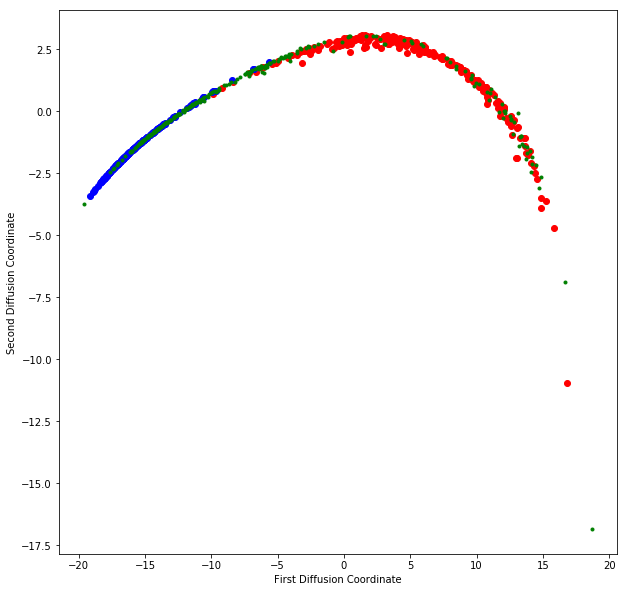

In [4]:
import matplotlib.pyplot as plt
from diffusionMap import diffuse
from scipy.spatial.distance import pdist,squareform

neigen  = 10
perc    = 30
p       = pdist(predTest)
D       = squareform(p)
eps     = np.square(np.percentile(p,perc))
diffMap = diffuse(D,neigen,eps)

plt.figure(figsize=(10,10))
s = np.where(test==0)[0]
plt.plot(diffMap.X[s,0],diffMap.X[s,1],'ro')
s = np.where(test==1)[0]
plt.plot(diffMap.X[s,0],diffMap.X[s,1],'bo')
s = np.where(test==-1)[0]
plt.plot(diffMap.X[s,0],diffMap.X[s,1],'g.')
plt.xlabel('First Diffusion Coordinate')
plt.ylabel('Second Diffusion Coordinate')
plt.show()

# Example of Visualization Using Diffusion Map and plotly

Repeats the plotting of the diffusion map above, with interactivity.

The values displayed by hovering over points are the predictor variables: the (M,I,D) statistics of Freeman et al. (2013), the (Gini,M20) statistics of Lotz, Primack, & Madau (2004), and the (C,A) statistics of Conselice (2003). Easy to see is that the C statistic is highly correlated with position along the diffusion map locus.

In [6]:
from plotly.offline import plot
import plotly.graph_objs as go
import numpy as np

sFail = np.where(test==-1)[0]
sLo   = np.where(test==0)[0]
sHi   = np.where(test==1)[0]

traceFail = go.Scatter(
    x         = diffMap.X[sFail,0],
    y         = diffMap.X[sFail,1],
    name      = 'Not Significant',
    text      = np.array([str(xx) for xx in predTest[sFail,:]]),
    hoverinfo = 'text',
    mode      = 'markers',
    marker    = dict(
        size  = 5,
        color = 'green'
    )
)
traceLo = go.Scatter(
    x         = diffMap.X[sLo,0],
    y         = diffMap.X[sLo,1],
    name      = 'Low Mass-Dominated',
    text      = np.array([str(xx) for xx in predTest[sLo,:]]),
    hoverinfo = 'text',
    mode      = 'markers',
    marker    = dict(
        size  = 10,
        color = 'red'
    )
)
traceHi = go.Scatter(
    x         = diffMap.X[sHi,0],
    y         = diffMap.X[sHi,1],
    name      = 'High Mass-Dominated',
    text      = np.array([str(xx) for xx in predTest[sHi,:]]),
    hoverinfo = 'text',
    mode      = 'markers',
    marker    = dict(
        size  = 10,
        color = 'blue'
    )
)

data = [traceFail,traceLo,traceHi]

layout = go.Layout(
    hovermode = 'closest',
    xaxis = dict(
        zeroline = False
    ),
    yaxis = dict(
        zeroline = False
    )
)

fig = go.Figure(data=data,layout=layout)

plot(fig,filename='galaxy-diffmap-scatter.html')

'file:///Users/peterfreeman/Dropbox/R2Python/pef_python/galaxy-diffmap-scatter.html'

# Example of Visualization via Boxplots

Boxplots a given (filtered) statistic. The examples indicate that there is a marked difference in the distributions of the statistics in class-0-dominated regions vs. class-1-dominated regions.

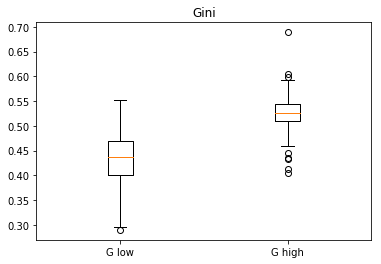

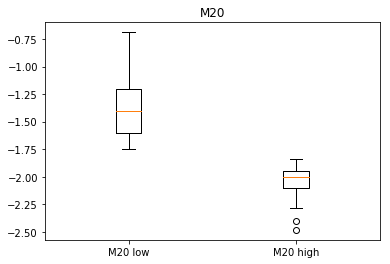

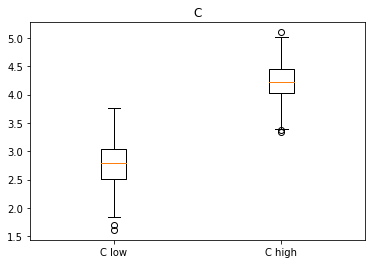

In [8]:
import matplotlib.pyplot as plt

sHi = np.where(test==1)[0]
sLo = np.where(test==0)[0]

plt.boxplot([predTest[sLo,3],predTest[sHi,3]],labels=['G low','G high'])
plt.title('Gini')
plt.show()
plt.boxplot([predTest[sLo,4],predTest[sHi,4]],labels=['M20 low','M20 high'])
plt.title('M20')
plt.show()
plt.boxplot([predTest[sLo,5],predTest[sHi,5]],labels=['C low','C high'])
plt.title('C')
plt.show()